# Preliminaries

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as stats
from scipy.stats import skew, kurtosis
from tqdm.notebook import tqdm
import datetime
from pandas_datareader import data as pdr
import yfinance as yf
np.random.seed(42)

# Google stock data

In [2]:
yf.pdr_override()
start = datetime.datetime(2021, 1, 1)
end = datetime.datetime(2022, 1, 1)
googlframe = pdr.get_data_yahoo("GOOGL", start="2020-01-01", end="2021-01-01")
display(googlframe.head())
display(googlframe.tail())

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,67.420502,68.433998,67.324501,68.433998,68.433998,27278000
2020-01-03,67.400002,68.687500,67.365997,68.075996,68.075996,23408000
2020-01-06,67.581497,69.916000,67.550003,69.890503,69.890503,46768000
2020-01-07,70.023003,70.175003,69.578003,69.755501,69.755501,34330000
2020-01-08,69.740997,70.592499,69.631500,70.251999,70.251999,35314000


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-24,86.449997,87.120499,86.217499,86.708000,86.708000,9312000
2020-12-28,87.245499,89.349998,87.091003,88.697998,88.697998,27650000
2020-12-29,89.361504,89.423500,87.755501,87.888000,87.888000,19726000
2020-12-30,88.250000,88.388000,86.400002,86.812500,86.812500,21026000
2020-12-31,86.863503,87.875000,86.804497,87.632004,87.632004,21070000


<AxesSubplot:xlabel='Date'>

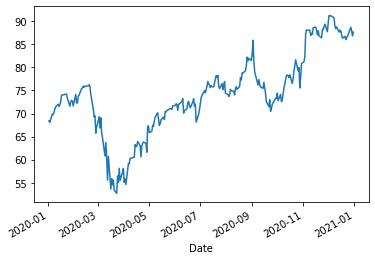

In [3]:
googlframe['Adj Close']['2020-01-01':'2021-01-01'].plot()

# SDE

$d S_{t}= r S_{t} d t+\sigma S_{t} dW_{t}$

In [4]:
from numpy import sqrt, exp, cumsum, sum, maximum, mean
from numpy.random import standard_normal

# Parameters

In [61]:
S0 = 87.63   # initial price
K = 100      # strike price
r = 0.01     # risk-free interest rate
sigma = 0.15 # volatility
T = 1        # time to maturity in years
N = 1000     # number of time steps
dt = T/N     # time step size
M = 1000     # number of simulations

# Base class for random walk models

In [6]:
class BaseSimulator:
    def __init__(self, model_name, S0, K, r, sigma, T, N, M, phis=[]):
        self.model_name = model_name
        self.S0 = S0  # initial price
        self.K = K    # strike price
        self.r = r    # risk-free interest rate
        self.sigma = sigma # volatility
        self.T = T    # time to maturity in years
        self.N = N    # number of time steps
        self.dt = T/N # time step size
        self.M = M    # number of simulations
        self.realisations = []  # full path of realisations
        self.expiry_prices = [] # expiry prices
        self.phis = phis # sequence of noise

    def get_option_price(self, option_type):
        # function for pricing option based on generated realisations
        raise NotImplementedError("Subclass must implement abstract method")

    def run_monte_carlo(self):
        # function for generating random walks/realisations
        raise NotImplementedError("Subclass must implement abstract method")
    
    def plot_n_realisations(self, n):
        x = np.linspace(0.0, self.T, self.N+1)
        for i in range(n):
            plt.plot(x, self.realisations[:,i])
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'Simulated Time Series using {self.model_name} method')
        plt.show()

# Euler-Maruyama method

$S_T=S_0 \exp \left\{\left(r-\frac{1}{2} \sigma^2\right) T+\sigma \phi \sqrt{T}\right\}$  
This is a closed form solution where the final price at expiry can be calculated in one giant step T.  
Integrated over [0,T]

In [7]:
# initialise random values
phi = standard_normal(M)

# Simulate I outcome
S = S0 * exp((r - 0.5 * sigma ** 2) * T + sigma * sqrt(T) * phi)
payoffs = maximum(S-K, 0)

# Calculate the Monte Carlo estimator
C0 = exp(-r * T) * sum(payoffs)/len(payoffs)
print("Estimated present value is %f" % C0)

Estimated present value is 1.687762


# Forward Euler-Maruyama method - slow
$S_{t+\delta t} = S_t(1+r \delta t+\sigma \phi \sqrt{\delta t})$

In [8]:
# function to run one simulation
def simulate_Euler_Maruyama():
    # Initialize the time series
    S = np.zeros(N+1)
    S[0] = S0
    
    # perform one realisation
    for i in range(N):
        _phi = np.random.normal(0, 1)
        S[i+1] = S[i] * (1 + r*dt + sigma*_phi*sqrt(dt))
    return S[-1]

start_time = time.time()
payoffs = maximum(np.array([simulate_Euler_Maruyama() for i in range(M)]) - K, 0)
option_price = exp(-r*T) * sum(payoffs)/len(payoffs)
print("Estimated present value is %f" % option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 1.545735
Computation time is:  4.9745


In [9]:
class Euler_Maruyama_simulator:
    def __init__(self, S0, K, r, sigma, T, N, M):
        self.S0 = S0
        self.K = K    # strike price
        self.r = r    # risk-free interest rate
        self.sigma = sigma # volatility
        self.T = T    # time to maturity in years
        self.N = N    # number of time steps
        self.dt = T/N # time step size
        self.M = M    # number of simulations
        self.realisations = [] # full path of realisations
        self.expiry_price = [] # expiry prices
        
    def perform_realisation(self):
        # Initialize the time series
        S = np.zeros(self.N+1)
        S[0] = self.S0

        # perform one realisaztion
        for i in range(self.N):
            _phi = np.random.normal(0, 1)
            S[i+1] = S[i] * (1 + self.r*self.dt + self.sigma*_phi*sqrt(self.dt))
        self.realisations.append(S)
        self.expiry_price.append(S[-1])
    
    def run_monte_carlo(self):
        for i in range(self.M) : self.perform_realisation()
        payoffs = maximum(np.array(self.expiry_price) - self.K, 0)
        option_price = exp(-self.r*self.T) * sum(payoffs)/len(payoffs)
        return option_price
    
    def plot_n_realisations(self, n):
        x = np.linspace(0.0, self.T, self.N+1)
        for i in range(n):
            plt.plot(x, self.realisations[i])
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Simulated Time Series using Euler-Maruyama method')
        plt.show()

In [10]:
start_time = time.time()
EM_simulator = Euler_Maruyama_simulator(S0, K, r, sigma, T, N, M)
EM_option_price = EM_simulator.run_monte_carlo()
print("Estimated present value is %f" % EM_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 1.614720
Computation time is:  4.8631


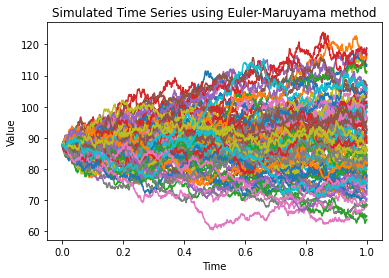

In [11]:
EM_simulator.plot_n_realisations(100)

# Forward Euler-Maruyama method - optimised
$S_{t+\delta t} = S_t(1+r \delta t+\sigma \phi \sqrt{\delta t})$

In [12]:
class Euler_Maruyama_fast_simulator(BaseSimulator):
    def get_option_price(self, option_type="c"):
        # c : call option | other : put option
        # calculate payoffs and dicounted option price
        self.expiry_prices = self.realisations[-1]
        payoffs = (self.expiry_prices - self.K) if (option_type=="c") else (self.K - self.expiry_prices)
        payoffs = maximum(payoffs, 0)
        option_price = exp(-self.r*self.T) * sum(payoffs)/self.M
        return option_price
    
    def run_monte_carlo(self):
        # initialise arrays of random variables
        if (len(self.phis) == 0):
            self.phis = standard_normal(size=(self.N, self.M))

        # perform simulations across each time steps
        delta_St = 1 + self.r*self.dt + self.sigma*np.sqrt(self.dt)*self.phis
        self.realisations = self.S0*np.cumprod(delta_St, axis=0)
        
        # prepend initial price S0 to the realisations
        self.realisations = np.concatenate((np.full(shape=(1, self.M), fill_value=self.S0), self.realisations))

### Call Option

In [13]:
start_time = time.time()
em_simulator = Euler_Maruyama_fast_simulator("Euler-Maruyama", S0, K, r, sigma, T, N, M)
em_simulator.run_monte_carlo()
em_option_price = em_simulator.get_option_price()
print("Estimated present value is %f" % em_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 1.758084
Computation time is:  0.0771


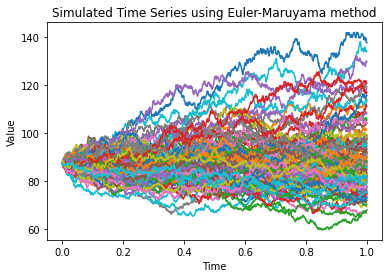

In [14]:
em_simulator.plot_n_realisations(100)

### Put Option

In [15]:
start_time = time.time()
em_simulator = Euler_Maruyama_fast_simulator("Euler-Maruyama", S0, K, r, sigma, T, N, M)
em_simulator.run_monte_carlo()
em_option_price = em_simulator.get_option_price("p")
print("Estimated present value is %f" % em_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 12.686185
Computation time is:  0.0623


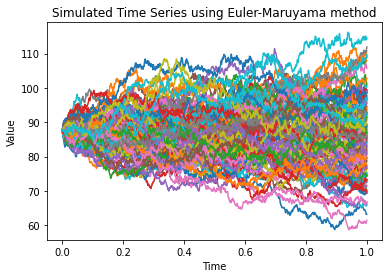

In [16]:
em_simulator.plot_n_realisations(100)

# Milstein method - slow
$S_{t+\delta t} = S_t\left(1+r \delta t+\sigma \phi \sqrt{\delta t}+\frac{1}{2} \sigma^2\left(\phi^2-1\right) \delta t\right)$

In [17]:
# function to run one simulation
def simulate_Milstein():
    # Initialize the time series
    S = np.zeros(N+1)
    S[0] = S0
    
    # perform one realisaztion
    for i in range(N):
        _phi = np.random.normal(0, 1)
        S[i+1] = S[i] * (1 + r*dt + sigma*_phi*sqrt(dt) + 0.5*(sigma**2)*(_phi**2 - 1)*dt)
    return S[-1]

start_time = time.time()
payoffs = maximum(np.array([simulate_Milstein() for i in range(M)]) - K, 0)
option_price = exp(-r*T) * sum(payoffs)/len(payoffs)
print("Estimated present value is %f" % option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 1.416357
Computation time is:  5.8167


In [18]:
class Milstein_simulator:
    def __init__(self, S0, K, r, sigma, T, N, M):
        self.S0 = S0
        self.K = K    # strike price
        self.r = r    # risk-free interest rate
        self.sigma = sigma # volatility
        self.T = T    # Final time
        self.N = N    # number of time steps
        self.dt = T/N # time step size
        self.M = M    # number of simulations
        self.realisations = []  # full paths of realisations
        self.expiry_prices = [] # expiry prices
        
    def perform_realisation(self):
        # Initialise the time series
        S = np.zeros(self.N+1)
        S[0] = self.S0

        # perform one realisaztion
        for i in range(self.N):
            _phi = np.random.normal(0, 1)
            S[i+1] = S[i] * (1 + self.r*self.dt + self.sigma*_phi*sqrt(self.dt) + 0.5*(self.sigma**2)*(_phi**2 - 1)*self.dt)
        self.realisations.append(S)
        self.expiry_prices.append(S[-1])
    
    def run_monte_carlo(self):
        for i in range(self.M) : self.perform_realisation()
        payoffs = maximum(np.array(self.expiry_prices) - K, 0)
        option_price = exp(-self.r*self.T) * sum(payoffs)/len(payoffs)
        return option_price
    
    def plot_n_realisations(self, n):
        x = np.linspace(0.0, self.T, self.N+1)
        for i in range(n):
            plt.plot(x, self.realisations[i])
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Simulated Time Series using Milstein method')
        plt.show()

In [19]:
start_time = time.time()
M_simulator = Milstein_simulator(S0, K, r, sigma, T, N, M)
M_option_price = M_simulator.run_monte_carlo()
print("Estimated present value is %f" % M_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 1.407625
Computation time is:  5.833


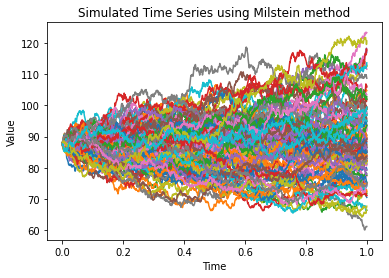

In [20]:
M_simulator.plot_n_realisations(100)

# Milstein method - optimised
$S_{t+\delta t} = S_t\left(1+r \delta t+\sigma \phi \sqrt{\delta t}+\frac{1}{2} \sigma^2\left(\phi^2-1\right) \delta t\right)$

In [21]:
class Milstein_fast_simulator(BaseSimulator):
    def get_option_price(self, option_type="c"):
        # c : call option | other : put option
        # calculate payoffs and dicounted option price
        self.expiry_prices = self.realisations[-1]
        payoffs = (self.expiry_prices - self.K) if (option_type=="c") else (self.K - self.expiry_prices)
        payoffs = maximum(payoffs, 0)
        option_price = exp(-self.r*self.T) * sum(payoffs)/self.M
        return option_price
    
    def run_monte_carlo(self):
        # initialise arrays of random variables
        if (len(self.phis) == 0):
            self.phis = standard_normal(size=(self.N, self.M))

        # perform simulations across each time steps
        delta_St = 1 + self.r*self.dt + self.sigma*np.sqrt(self.dt)*self.phis + 0.5*(self.sigma**2)*(np.square(self.phis)-1)*self.dt
        self.realisations = self.S0*np.cumprod(delta_St, axis=0)
        
        # prepend initial price S0 to the realisations
        self.realisations = np.concatenate((np.full(shape=(1, self.M), fill_value=self.S0), self.realisations))

### Call Option

In [22]:
start_time = time.time()
mil_simulator = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, M)
mil_simulator.run_monte_carlo()
mil_option_price = mil_simulator.get_option_price()
print("Estimated present value is %f" % mil_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 1.897618
Computation time is:  0.081


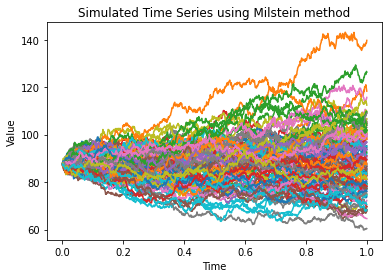

In [23]:
mil_simulator.plot_n_realisations(100)

### Put Option

In [24]:
start_time = time.time()
mil_simulator = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, M)
mil_simulator.run_monte_carlo()
mil_option_price = mil_simulator.get_option_price("p")
print("Estimated present value is %f" % mil_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 12.906997
Computation time is:  0.0679


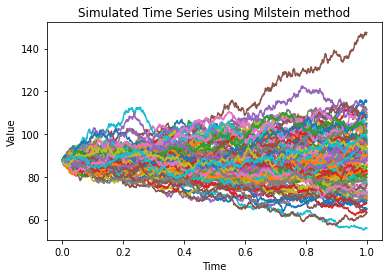

In [25]:
mil_simulator.plot_n_realisations(100)

# Monte Carlo Simulator
The same set of phis is used for both Euler-Maruyama and Milstein methods for comparison.

In [26]:
class MC_simulator:
    def __init__(self, S0, K, r, sigma, T, N, I):
        self.S0 = S0  # initial asset price
        self.K = K    # strike price
        self.r = r    # risk-free interest rate
        self.sigma = sigma # volatility
        self.T = T    # Final time
        self.N = N    # number of time steps
        self.dt = T/N # time step size
        self.I = I    # number of simulations
        self.Milstein_realisations = [] # full path of realisations using Milstein
        self.Milstein_expiry_prices = []
        self.Euler_Maruyama_realisations = [] # full path of realisations using Euler Maruyama
        self.Euler_Maruyama_expiry_prices = []
        self.phis = None # sequence of noise
    
    def perform_Euler_Maruyama_realisation(self):
        # Initialize the time series
        S = np.zeros(self.N+1)
        S[0] = self.S0

        # perform one realisation
        for i in range(self.N):
            S[i+1] = S[i] * (1 + self.r*self.dt + self.sigma*self.phis[i]*sqrt(self.dt))
        self.Euler_Maruyama_realisations.append(S)
        self.Euler_Maruyama_expiry_prices.append(S[-1])
        
    def perform_Milstein_realisation(self):
        # Initialize the time series
        S = np.zeros(self.N+1)
        S[0] = self.S0

        # perform one realisation
        for i in range(self.N):
            S[i+1] = S[i] * (1 + self.r*self.dt + sigma*self.phis[i]*sqrt(self.dt) + 0.5*(self.sigma**2)*(self.phis[i]**2 - 1)*self.dt)
        self.Milstein_realisations.append(S)
        self.Milstein_expiry_prices.append(S[-1])
    
    def calculate_option_price(self, expiry_prices):
        payoffs = maximum(np.array(expiry_prices) - self.K, 0)
        option_price = exp(-self.r*self.T) * sum(payoffs)/len(payoffs)
        return option_price
        
    def run_monte_carlo(self):
        # Run I number of simulations
        print('Start running simulations...')
        for i in tqdm(range(self.I)):
            self.phis = standard_normal(self.N)
            self.perform_Euler_Maruyama_realisation()
            self.perform_Milstein_realisation()
        
        # price the option
        EM_option_price = self.calculate_option_price(self.Euler_Maruyama_expiry_prices)
        M_option_price = self.calculate_option_price(self.Milstein_expiry_prices)
        return (EM_option_price, M_option_price)
    
    def plot_n_realisations(self, n):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))
        # plots Euler-Maruyama realisations
        x = np.linspace(0.0, self.T, self.N+1)
        for i in range(n):
            axes[0].plot(x, self.Euler_Maruyama_realisations[i])   
        axes[0].set_xlabel('Time')
        axes[0].set_ylabel('Value')
        axes[0].set_title('Simulated Time Series using Euler-Maruyama method')
        
        # plots Milstein realisations
        for i in range(n):
            axes[1].plot(x, self.Milstein_realisations[i])   
        axes[1].set_xlabel('Time')
        axes[1].set_ylabel('Value')
        axes[1].set_title('Simulated Time Series using Milstein method')
        
        fig.tight_layout()
        plt.show()
    
    def comparing_ith_realisations(self, ith_rls):
        x = np.linspace(0.0, self.T, self.N+1)
        plt.figure(figsize=(13, 6))
        plt.plot(x, self.Euler_Maruyama_realisations[ith_rls], label='Euler-Maruyama')
        plt.plot(x, self.Milstein_realisations[ith_rls], label='Milstein')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Comparing Simulated Time Series using both methods')
        plt.legend()
        plt.show()

## optimised Monte Carlo simulator
The same set of phis is used for both Euler-Maruyama and Milstein methods for comparison.

In [27]:
class MC_simulator_optimised:
    def __init__(self, S0, K, r, sigma, T, N, M, phis=[]):
        self.S0 = S0  # initial asset price
        self.K = K    # strike price
        self.r = r    # risk-free interest rate
        self.sigma = sigma # volatility
        self.T = T    # Final time
        self.N = N    # number of time steps
        self.dt = T/N # time step size
        self.M = M    # number of simulations
        self.phis = phis # sequence of noise
        self.mil_simulator = None
        self.em_simulator = None
        self.initialise_models()
    
    def initialise_models(self):
        # initialise arrays of noises
        if (len(self.phis) == 0):
            self.phis = standard_normal(size=(self.N, self.M))
        # initialise Milstein object
        self.mil_simulator = Milstein_fast_simulator("Milstein", self.S0, self.K, self.r, self.sigma, self.T, self.N, self.M, self.phis)
        # initialise Euler Maruyama object
        self.em_simulator = Euler_Maruyama_fast_simulator("Euler-Maruyama", self.S0, self.K, self.r, self.sigma, self.T, self.N, self.M, self.phis)
        print("model objects initialised...")
        
    def run_monte_carlo(self, option_type="c"):
        print('Start running simulations...')
        # price the option
        self.em_simulator.run_monte_carlo()
        EM_option_price = self.em_simulator.get_option_price(option_type)
        
        self.mil_simulator.run_monte_carlo()
        M_option_price = self.mil_simulator.get_option_price(option_type)
        return (EM_option_price, M_option_price)
    
    def comparing_ith_realisations(self, ith_rls):
        x = np.linspace(0.0, self.T, self.N+1)
        plt.figure(figsize=(13, 6))
        plt.plot(x, self.em_simulator.realisations[:,ith_rls], label='Euler-Maruyama')
        plt.plot(x, self.mil_simulator.realisations[:,ith_rls], label='Milstein')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Comparing Simulated Time Series using both methods')
        plt.legend()
        plt.show()
    
    def plot_n_realisations(self, n):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))
        # plots Euler-Maruyama realisations
        x = np.linspace(0.0, self.T, self.N+1)
        for i in range(n):
            axes[0].plot(x, self.em_simulator.realisations[:,i])   
        axes[0].set_xlabel('Time')
        axes[0].set_ylabel('Value')
        axes[0].set_title('Simulated Time Series using Euler-Maruyama method')
        
        # plots Milstein realisations
        for i in range(n):
            axes[1].plot(x, self.mil_simulator.realisations[:,i])   
        axes[1].set_xlabel('Time')
        axes[1].set_ylabel('Value')
        axes[1].set_title('Simulated Time Series using Milstein method')
        
        fig.tight_layout()
        plt.show()


### European Call Option

In [28]:
start_time = time.time()
mc_simulator = MC_simulator_optimised(S0, K, r, sigma, T, N, M)
(EM_option_price, M_option_price) = mc_simulator.run_monte_carlo()
print("Euler-Maruyama: Estimated present value is %f" % EM_option_price)
print("Milstein: Estimated present value is %f" % M_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

model objects initialised...
Start running simulations...
Euler-Maruyama: Estimated present value is 1.531466
Milstein: Estimated present value is 1.530385
Computation time is:  0.1019


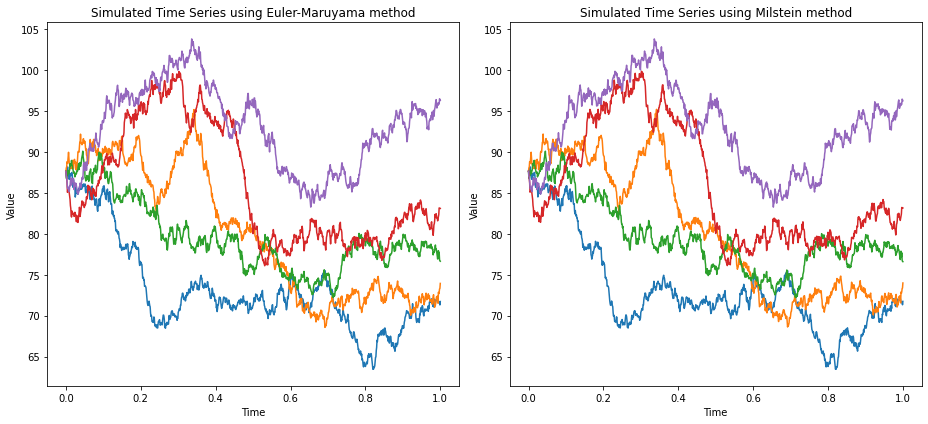

In [29]:
mc_simulator.plot_n_realisations(5)

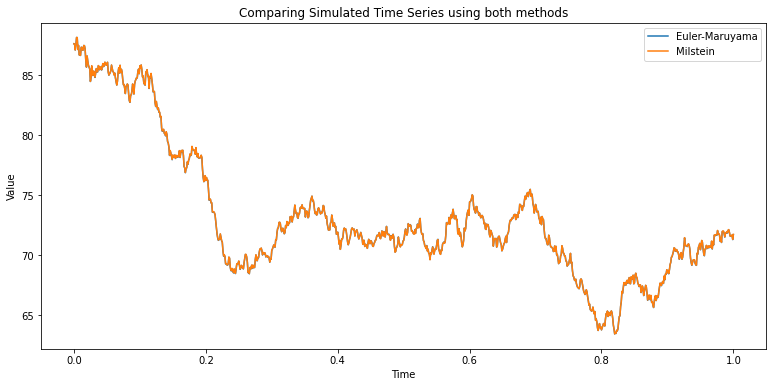

In [30]:
mc_simulator.comparing_ith_realisations(0)

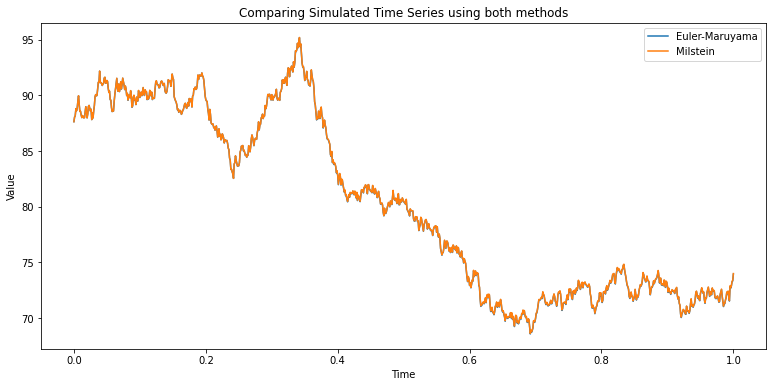

In [31]:
mc_simulator.comparing_ith_realisations(1)

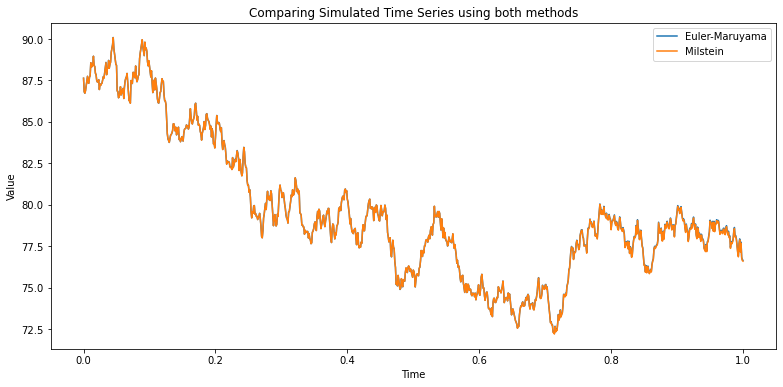

In [32]:
mc_simulator.comparing_ith_realisations(2)

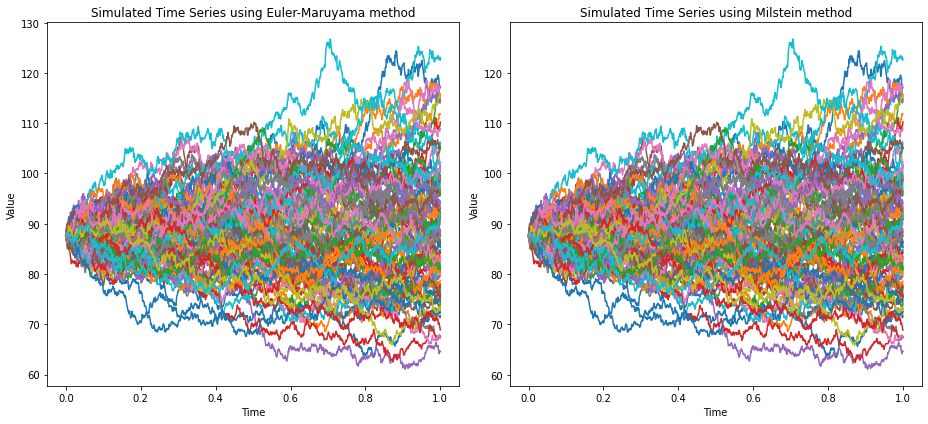

In [33]:
mc_simulator.plot_n_realisations(100)

### European Put Option

In [34]:
start_time = time.time()
mc_simulator = MC_simulator_optimised(S0, K, r, sigma, T, N, M)
(EM_option_price, M_option_price) = mc_simulator.run_monte_carlo("p")
print("Euler-Maruyama: Estimated present value is %f" % EM_option_price)
print("Milstein: Estimated present value is %f" % M_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

model objects initialised...
Start running simulations...
Euler-Maruyama: Estimated present value is 13.169808
Milstein: Estimated present value is 13.170558
Computation time is:  0.166


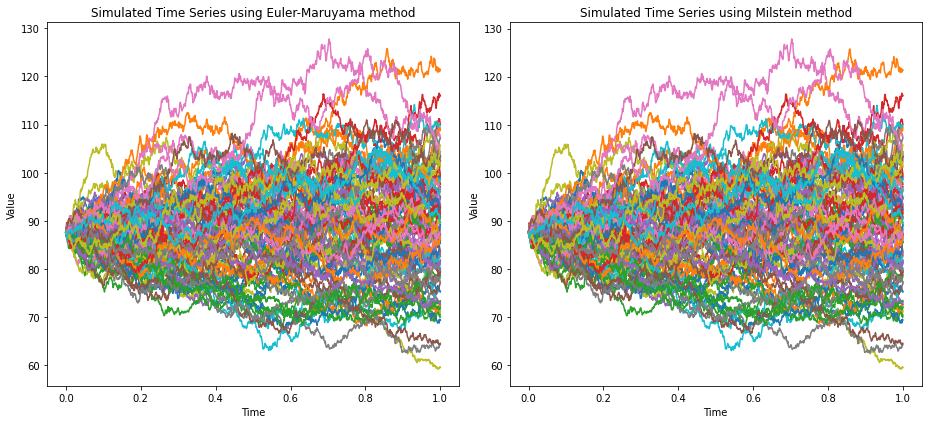

In [35]:
mc_simulator.plot_n_realisations(100)

# Barrier Options

1. up-and-in call option
1. up-and-out call option
1. down-and-in call option
1. down-and-out call option
1. up-and-in put option
1. up-and-out put option
1. down-and-in put option
1. down-and-out put option

In [36]:
# experimentation
N = 5
M = 5
H = 100
start_time = time.time()
mil_simulator = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, M)
mil_simulator.run_monte_carlo()
mil_option_price = mil_simulator.get_option_price()
print("Estimated present value is %f" % mil_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

print(mil_simulator.realisations)
mask = np.any(mil_simulator.realisations >= H, axis=0)
print(mask)

cloned_rels = np.copy(mil_simulator.realisations)
cloned_rels[:,mask] = 0
print(cloned_rels, end="\n")

payoffs = np.maximum(0, K - cloned_rels[-1][cloned_rels[-1] != 0])
print(payoffs, end="\n")
C0 = np.exp(-r*T)*np.sum(payoffs)/M
print(C0, end="\n")

Estimated present value is 0.000000
Computation time is:  0.0047
[[87.63       87.63       87.63       87.63       87.63      ]
 [95.12433842 78.60291833 98.13414036 86.4468799  89.35606438]
 [93.25918279 72.97180527 98.59423816 83.53918499 97.02774849]
 [91.38505353 71.67980564 98.38344252 80.82561517 88.47349992]
 [86.2866065  75.04842713 94.02316197 78.63398136 94.61622985]
 [81.79659908 79.74757577 92.02863984 81.67423764 94.82326274]]
[False False False False False]
[[87.63       87.63       87.63       87.63       87.63      ]
 [95.12433842 78.60291833 98.13414036 86.4468799  89.35606438]
 [93.25918279 72.97180527 98.59423816 83.53918499 97.02774849]
 [91.38505353 71.67980564 98.38344252 80.82561517 88.47349992]
 [86.2866065  75.04842713 94.02316197 78.63398136 94.61622985]
 [81.79659908 79.74757577 92.02863984 81.67423764 94.82326274]]
[18.20340092 20.25242423  7.97136016 18.32576236  5.17673726]
13.846774588809518


In [80]:
class BarrierOption(MC_simulator_optimised):
    def __init__(self, S0, K, r, sigma, T, N, M, barrier_type, H_bound, L_bound):
        super().__init__(S0, K, r, sigma, T, N, M)
        self.barrier_type = barrier_type # int: corresponds to the indexes listed above
        self.H_bound = H_bound   # upper barrier
        self.L_bound = L_bound   # lower barrier
        self.em_mask = None # mask for Euler-Maruyama
        self.m_mask = None  # mask for Milstein
        self.title = 'European Up-and-Out Call Option'
        self.main_type = "Call"
    
    def calculate_option_price(self, mask, realisations, model_type):
        S_expiry = realisations[-1,:].copy()
        S_expiry[mask] = 0
        
        """
        barrier_type < 5 : call option => ST - K
        barrier_type >= 5 : put option = K - ST
        """
        payoffs = (S_expiry[S_expiry[:]!=0] - self.K) if (self.barrier_type < 5) else (self.K - S_expiry[S_expiry[:]!=0])
        payoffs = np.maximum(0, payoffs)
        option_price = np.exp(-self.r*self.T)*np.sum(payoffs)/self.M

        attr_name = 'em_mask' if model_type == 0 else 'm_mask'
        setattr(self, attr_name, mask)
        return option_price
        
    def up_and_in(self, realisations, model_type):
        self.title = 'European Up-and-In ' + ('Call Option' if (self.barrier_type < 5) else 'Put Option')
        # change realisation values to 0 based on indexing mask
        mask = np.any(realisations >= self.H_bound, axis=0)
        # reversing mask so realisations below barrier are nullified
        mask = ~mask
        return self.calculate_option_price(mask, realisations, model_type)
    
    def up_and_out(self, realisations, model_type):
        self.title = 'European Up-and-Out ' + ('Call Option' if (self.barrier_type < 5) else 'Put Option')
        # change realisation values to 0 based on indexing mask
        mask = np.any(realisations >= self.H_bound, axis=0)
        return self.calculate_option_price(mask, realisations, model_type)
    
    def down_and_in(self, realisations, model_type):
        self.title = 'European Down-and-In ' + ('Call Option' if (self.barrier_type < 5) else 'Put Option')
        # change realisation values to 0 based on indexing mask
        mask = np.any(realisations <= self.L_bound, axis=0)
        # reversing mask so realisations above barrier are nullified
        mask = ~mask
        return self.calculate_option_price(mask, realisations, model_type)

    def down_and_out(self, realisations, model_type):
        self.title = 'European Down-and-Out ' + ('Call Option' if (self.barrier_type < 5) else 'Put Option')
        # change realisation values to 0 based on indexing mask
        mask = np.any(realisations <= self.L_bound, axis=0)
        return self.calculate_option_price(mask, realisations, model_type)

    def run_monte_carlo(self):
        print('Start running simulations...')
        # run simulations
        self.main_type = "Call" if (self.barrier_type < 5) else "Put"
        [EM_option_price, M_option_price] = super().run_monte_carlo('c' if self.main_type=="Call" else 'p')
        
        # price option based on barriers
        select_barrier = {
            1 : self.up_and_in,
            2 : self.up_and_out,
            3 : self.down_and_in,
            4 : self.down_and_out,
            5 : self.up_and_in,
            6 : self.up_and_out,
            7 : self.down_and_in,
            8 : self.down_and_out
        }
        
        EM_barrier_price = select_barrier.get(self.barrier_type, self.up_and_in)(self.em_simulator.realisations, 0)
        M_barrier_price = select_barrier.get(self.barrier_type, self.up_and_in)(self.mil_simulator.realisations, 1)

        return (EM_option_price, M_option_price, EM_barrier_price, M_barrier_price)
    
    def plot_barrier_paths(self, random_walk="EM"):
        random_walks = self.em_simulator.realisations if random_walk=="EM" else self.mil_simulator.realisations
        plt.figure(figsize=(16, 6))
        
        # plot realisations
        plt.plot(np.linspace(0, self.T, self.N+1),random_walks[:,~self.em_mask],'g', alpha=0.5)
        plt.plot(0,0, 'g', label='active')
        plt.plot(np.linspace(0, self.T, self.N+1),random_walks[:,self.em_mask],'r', alpha=0.3)
        plt.plot(0,0, 'r', label='inactive')
        
        # plot barriers
        if (self.barrier_type < 3 or (self.barrier_type > 4 and self.barrier_type < 7)):
            plt.plot([0, self.T],[self.H_bound, self.H_bound], 'k--',linewidth=2.0, label='H_barrier')
        else:
            plt.plot([0, self.T],[self.L_bound, self.L_bound], 'k--',linewidth=2.0, label='L_barrier')

        plt.plot([0, self.T],[self.K, self.K], '--', color='blue',linewidth=2.0, label='strike price')
        plt.xlim(0,1)
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.title(self.title)
        plt.legend()
        plt.show()

## 1. European Up-and-In Call Option

In [81]:
barrier_option = BarrierOption(S0, 95, r, sigma, T, N, M, 1, 100, 75)
(EM_option_price, M_option_price, EM_barrier, M_barrier) = barrier_option.run_monte_carlo()
print("")
print(f'''{"Method":<{19}}{"Option Type":<{34}}{"Estimated Price":<{10}}''')
print(f'''{"------":<{19}}{"-----------":<{34}}{"---------------":<{10}}''')
print(f'''{"Euler-Maruyama":<{19}}{barrier_option.main_type:<{34}}{EM_option_price:<{10}}''')
print(f'''{"Milstein":<{19}}{barrier_option.main_type:<{34}}{M_option_price:<{10}}''')
print(f'''{"Euler-Maruyama":<{19}}{barrier_option.title:<{34}}{EM_barrier:<{10}}''')
print(f'''{"Milstein":<{19}}{barrier_option.title:<{34}}{M_barrier:<{10}}''')

model objects initialised...
Start running simulations...
Start running simulations...

Method             Option Type                       Estimated Price
------             -----------                       ---------------
Euler-Maruyama     Call                              3.138716563615897
Milstein           Call                              3.1395155326284607
Euler-Maruyama     European Up-and-In Call Option    3.0852421221857713
Milstein           European Up-and-In Call Option    3.0861698969485234


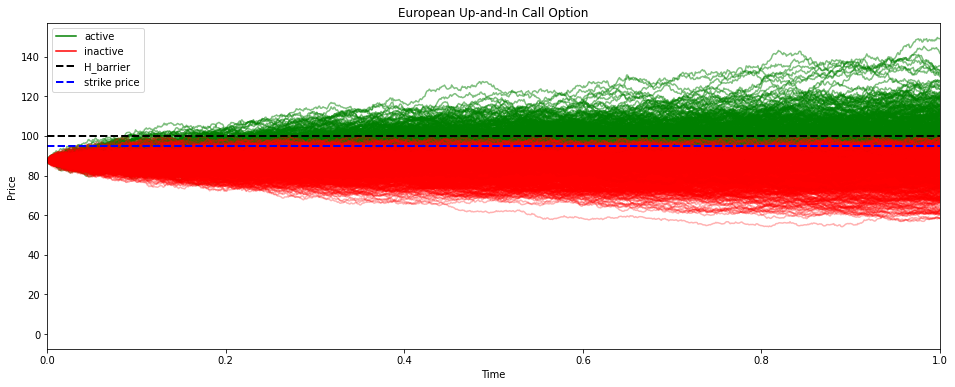

In [82]:
barrier_option.plot_barrier_paths()

## 2. European Up-and-Out Call Option

In [83]:
barrier_option = BarrierOption(S0, 95, r, sigma, T, N, M, 2, 100, 75)
(EM_option_price, M_option_price, EM_barrier, M_barrier) = barrier_option.run_monte_carlo()
print("")
print(f'''{"Method":<{19}}{"Option Type":<{34}}{"Estimated Price":<{10}}''')
print(f'''{"------":<{19}}{"-----------":<{34}}{"---------------":<{10}}''')
print(f'''{"Euler-Maruyama":<{19}}{barrier_option.main_type:<{34}}{EM_option_price:<{10}}''')
print(f'''{"Milstein":<{19}}{barrier_option.main_type:<{34}}{M_option_price:<{10}}''')
print(f'''{"Euler-Maruyama":<{19}}{barrier_option.title:<{34}}{EM_barrier:<{10}}''')
print(f'''{"Milstein":<{19}}{barrier_option.title:<{34}}{M_barrier:<{10}}''')

model objects initialised...
Start running simulations...
Start running simulations...

Method             Option Type                       Estimated Price
------             -----------                       ---------------
Euler-Maruyama     Call                              2.702495951487195
Milstein           Call                              2.7025486189155195
Euler-Maruyama     European Up-and-Out Call Option   0.033055206281794064
Milstein           European Up-and-Out Call Option   0.033015349652577


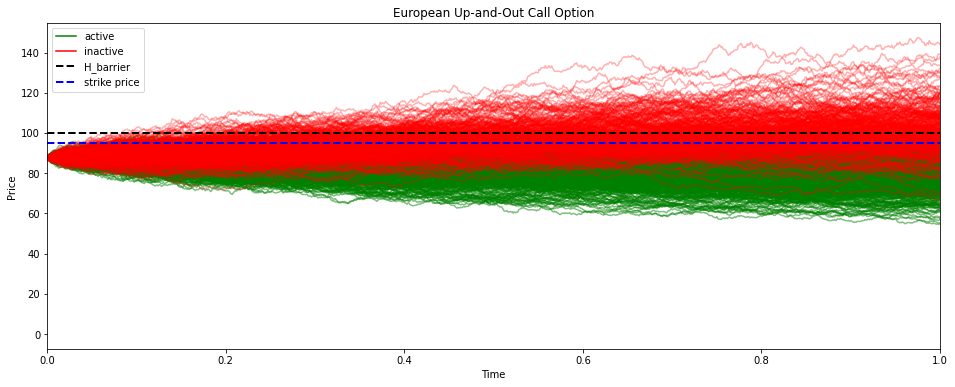

In [84]:
barrier_option.plot_barrier_paths()

## 3. European Down-and-In Call Option

In [85]:
barrier_option = BarrierOption(S0, 95, r, sigma, T, N, M, 3, 100, 80)
(EM_option_price, M_option_price, EM_barrier, M_barrier) = barrier_option.run_monte_carlo()
print("")
print(f'''{"Method":<{19}}{"Option Type":<{34}}{"Estimated Price":<{10}}''')
print(f'''{"------":<{19}}{"-----------":<{34}}{"---------------":<{10}}''')
print(f'''{"Euler-Maruyama":<{19}}{barrier_option.main_type:<{34}}{EM_option_price:<{10}}''')
print(f'''{"Milstein":<{19}}{barrier_option.main_type:<{34}}{M_option_price:<{10}}''')
print(f'''{"Euler-Maruyama":<{19}}{barrier_option.title:<{34}}{EM_barrier:<{10}}''')
print(f'''{"Milstein":<{19}}{barrier_option.title:<{34}}{M_barrier:<{10}}''')

model objects initialised...
Start running simulations...
Start running simulations...

Method             Option Type                       Estimated Price
------             -----------                       ---------------
Euler-Maruyama     Call                              2.5977841286295726
Milstein           Call                              2.598126183904845
Euler-Maruyama     European Down-and-In Call Option  0.19142201557094993
Milstein           European Down-and-In Call Option  0.19179615185333815


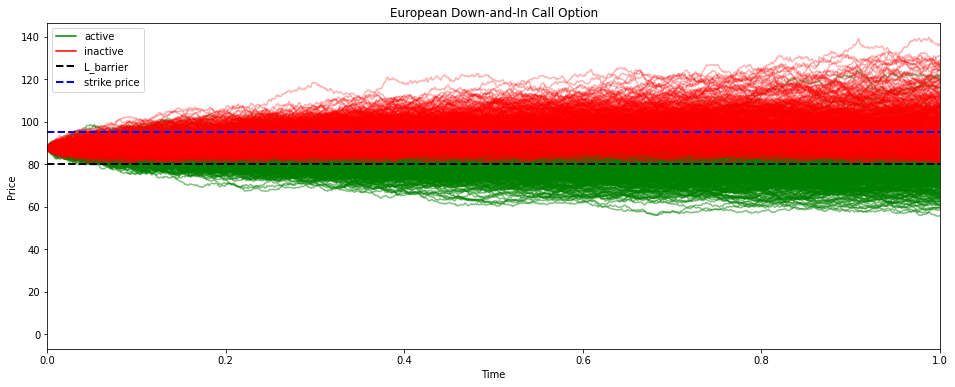

In [86]:
barrier_option.plot_barrier_paths()

## 4. European Down-and-Out Call Option

In [87]:
barrier_option = BarrierOption(S0, 95, r, sigma, T, N, M, 4, 100, 80)
(EM_option_price, M_option_price, EM_barrier, M_barrier) = barrier_option.run_monte_carlo()
print("")
print(f'''{"Method":<{19}}{"Option Type":<{34}}{"Estimated Price":<{10}}''')
print(f'''{"------":<{19}}{"-----------":<{34}}{"---------------":<{10}}''')
print(f'''{"Euler-Maruyama":<{19}}{barrier_option.main_type:<{34}}{EM_option_price:<{10}}''')
print(f'''{"Milstein":<{19}}{barrier_option.main_type:<{34}}{M_option_price:<{10}}''')
print(f'''{"Euler-Maruyama":<{19}}{barrier_option.title:<{34}}{EM_barrier:<{10}}''')
print(f'''{"Milstein":<{19}}{barrier_option.title:<{34}}{M_barrier:<{10}}''')

model objects initialised...
Start running simulations...
Start running simulations...

Method             Option Type                       Estimated Price
------             -----------                       ---------------
Euler-Maruyama     Call                              2.582397237122063
Milstein           Call                              2.583719424826745
Euler-Maruyama     European Down-and-Out Call Option 2.31592902855613
Milstein           European Down-and-Out Call Option 2.3166884566106494


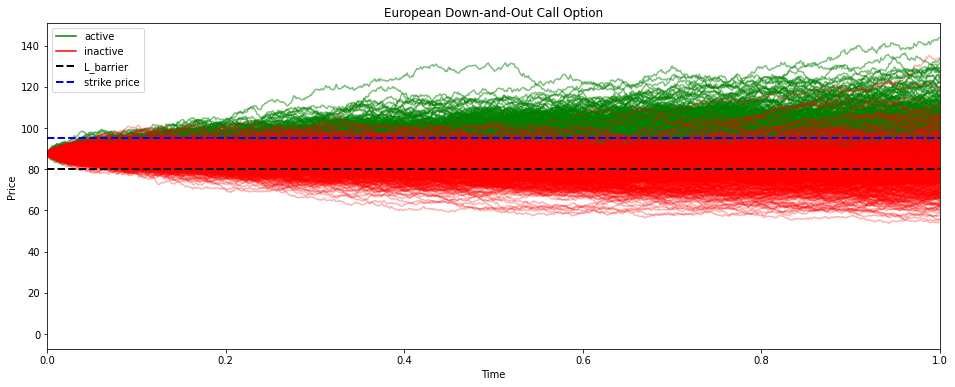

In [88]:
barrier_option.plot_barrier_paths()

## 5. European Up-and-In Put Option

In [89]:
barrier_option = BarrierOption(S0, 95, r, sigma, T, N, M, 5, 100, 80)
(EM_option_price, M_option_price, EM_barrier, M_barrier) = barrier_option.run_monte_carlo()
print("")
print(f'''{"Method":<{19}}{"Option Type":<{34}}{"Estimated Price":<{10}}''')
print(f'''{"------":<{19}}{"-----------":<{34}}{"---------------":<{10}}''')
print(f'''{"Euler-Maruyama":<{19}}{barrier_option.main_type:<{34}}{EM_option_price:<{10}}''')
print(f'''{"Milstein":<{19}}{barrier_option.main_type:<{34}}{M_option_price:<{10}}''')
print(f'''{"Euler-Maruyama":<{19}}{barrier_option.title:<{34}}{EM_barrier:<{10}}''')
print(f'''{"Milstein":<{19}}{barrier_option.title:<{34}}{M_barrier:<{10}}''')

model objects initialised...
Start running simulations...
Start running simulations...

Method             Option Type                       Estimated Price
------             -----------                       ---------------
Euler-Maruyama     Put                               8.968216972936709
Milstein           Put                               8.967096271241644
Euler-Maruyama     European Up-and-In Put Option     0.7040692224241653
Milstein           European Up-and-In Put Option     0.7037354385290189


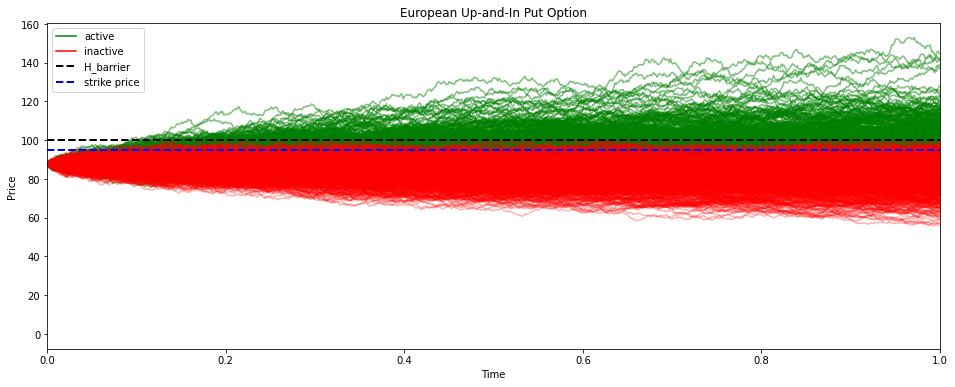

In [90]:
barrier_option.plot_barrier_paths()

## 6. European Up-and-Out Put Option

In [91]:
barrier_option = BarrierOption(S0, 95, r, sigma, T, N, M, 6, 100, 80)
(EM_option_price, M_option_price, EM_barrier, M_barrier) = barrier_option.run_monte_carlo()
print("")
print(f'''{"Method":<{19}}{"Option Type":<{34}}{"Estimated Price":<{10}}''')
print(f'''{"------":<{19}}{"-----------":<{34}}{"---------------":<{10}}''')
print(f'''{"Euler-Maruyama":<{19}}{barrier_option.main_type:<{34}}{EM_option_price:<{10}}''')
print(f'''{"Milstein":<{19}}{barrier_option.main_type:<{34}}{M_option_price:<{10}}''')
print(f'''{"Euler-Maruyama":<{19}}{barrier_option.title:<{34}}{EM_barrier:<{10}}''')
print(f'''{"Milstein":<{19}}{barrier_option.title:<{34}}{M_barrier:<{10}}''')

model objects initialised...
Start running simulations...
Start running simulations...

Method             Option Type                       Estimated Price
------             -----------                       ---------------
Euler-Maruyama     Put                               9.442458827585583
Milstein           Put                               9.444004810479631
Euler-Maruyama     European Up-and-Out Put Option    8.823786797709138
Milstein           European Up-and-Out Put Option    8.834517465597353


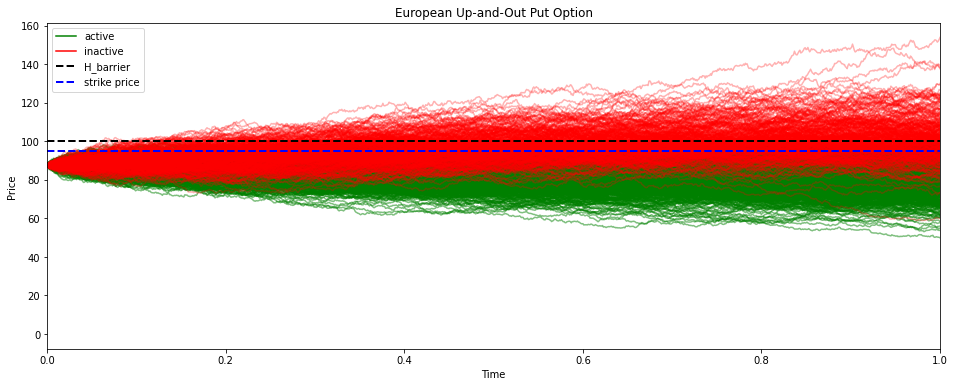

In [92]:
barrier_option.plot_barrier_paths()

## 7. European Down-and-In Put Option

In [93]:
barrier_option = BarrierOption(S0, 95, r, sigma, T, N, M, 7, 100, 80)
(EM_option_price, M_option_price, EM_barrier, M_barrier) = barrier_option.run_monte_carlo()
print("")
print(f'''{"Method":<{19}}{"Option Type":<{34}}{"Estimated Price":<{10}}''')
print(f'''{"------":<{19}}{"-----------":<{34}}{"---------------":<{10}}''')
print(f'''{"Euler-Maruyama":<{19}}{barrier_option.main_type:<{34}}{EM_option_price:<{10}}''')
print(f'''{"Milstein":<{19}}{barrier_option.main_type:<{34}}{M_option_price:<{10}}''')
print(f'''{"Euler-Maruyama":<{19}}{barrier_option.title:<{34}}{EM_barrier:<{10}}''')
print(f'''{"Milstein":<{19}}{barrier_option.title:<{34}}{M_barrier:<{10}}''')

model objects initialised...
Start running simulations...
Start running simulations...

Method             Option Type                       Estimated Price
------             -----------                       ---------------
Euler-Maruyama     Put                               9.577518668368551
Milstein           Put                               9.575656741325012
Euler-Maruyama     European Down-and-In Put Option   8.338058857971673
Milstein           European Down-and-In Put Option   8.351067127637997


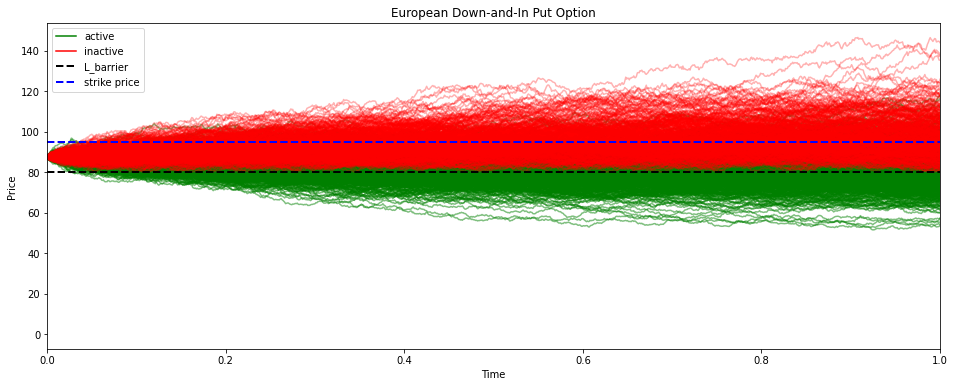

In [94]:
barrier_option.plot_barrier_paths()

## 8. European Down-and-Out Put Option

In [95]:
barrier_option = BarrierOption(S0, 95, r, sigma, T, N, M, 8, 100, 80)
(EM_option_price, M_option_price, EM_barrier, M_barrier) = barrier_option.run_monte_carlo()
print("")
print(f'''{"Method":<{19}}{"Option Type":<{34}}{"Estimated Price":<{10}}''')
print(f'''{"------":<{19}}{"-----------":<{34}}{"---------------":<{10}}''')
print(f'''{"Euler-Maruyama":<{19}}{barrier_option.main_type:<{34}}{EM_option_price:<{10}}''')
print(f'''{"Milstein":<{19}}{barrier_option.main_type:<{34}}{M_option_price:<{10}}''')
print(f'''{"Euler-Maruyama":<{19}}{barrier_option.title:<{34}}{EM_barrier:<{10}}''')
print(f'''{"Milstein":<{19}}{barrier_option.title:<{34}}{M_barrier:<{10}}''')

model objects initialised...
Start running simulations...
Start running simulations...

Method             Option Type                       Estimated Price
------             -----------                       ---------------
Euler-Maruyama     Put                               9.33357749110316
Milstein           Put                               9.332545481816666
Euler-Maruyama     European Down-and-Out Put Option  1.3624494241495722
Milstein           European Down-and-Out Put Option  1.359140839207723


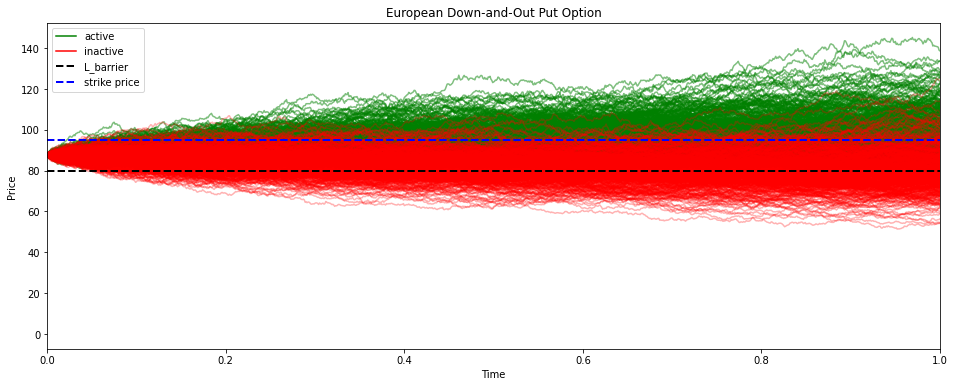

In [96]:
barrier_option.plot_barrier_paths()

# Asian Option